In [174]:
import requests
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [157]:
df = pd.read_csv("pga_data.csv")
df.head(5)


,Player_initial_last,tournament id,player id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,...,purse,season,no_cut,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Ancer,401353224,9261,288,289,60.0,51.1,56,3,7.6,...,12.0,2022,0,T32,0.20,-0.13,-0.08,0.86,0.65,0.85
1,A. Hadwin,401353224,5548,288,286,72.5,61.5,61,8,13.0,...,12.0,2022,0,T18,0.36,0.75,0.31,0.18,1.24,1.60
2,A. Lahiri,401353224,4989,144,147,21.5,17.4,27,0,0.0,...,12.0,2022,0,CUT,-0.56,0.74,-1.09,0.37,0.02,-0.54
3,A. Long,401353224,6015,144,151,20.5,13.6,17,0,0.4,...,12.0,2022,0,CUT,-1.46,-1.86,-0.02,0.80,-1.08,-2.54
4,A. Noren,401353224,3832,144,148,23.5,18.1,23,0,1.2,...,12.0,2022,0,CUT,0.53,-0.36,-1.39,0.19,-1.56,-1.04


# EDA

Numeric summary saved to: numeric_summary.png
Categorical summary saved to: categorical_summary.png


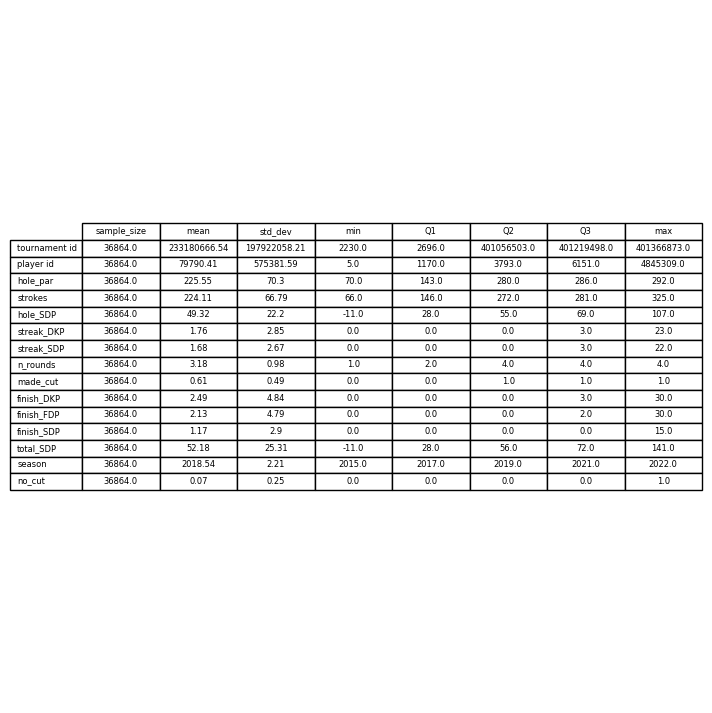

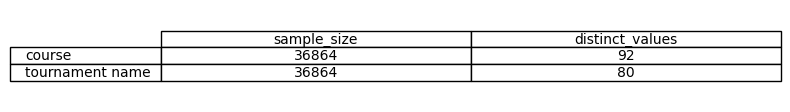

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_df(df):
    # Summary for integer (numeric) variables
    int_columns = df.select_dtypes(include='int')
    numeric_summary = int_columns.describe().T
    numeric_summary['sample_size'] = int_columns.count()
    numeric_summary['mean'] = int_columns.mean()
    numeric_summary['std_dev'] = int_columns.std()
    numeric_summary['min'] = int_columns.min()
    numeric_summary['Q1'] = int_columns.quantile(0.25)
    numeric_summary['Q2'] = int_columns.median()
    numeric_summary['Q3'] = int_columns.quantile(0.75)
    numeric_summary['max'] = int_columns.max()
    numeric_summary = numeric_summary[['sample_size', 'mean', 'std_dev', 'min', 'Q1', 'Q2', 'Q3', 'max']].round(2)
    
    # Summary for specified categorical variables (course and tournament_name)
    categorical_summary = pd.DataFrame(columns=['sample_size', 'distinct_values'])
    for col in ['course', 'tournament name']:
        if col in df.columns:
            sample_size = len(df[col].dropna())
            distinct_values = df[col].nunique()
            categorical_summary.loc[col] = [sample_size, distinct_values]

    # Save numeric summary as an image
    fig, ax = plt.subplots(figsize=(8, len(numeric_summary) * 0.6))
    ax.axis('off')
    ax.table(cellText=numeric_summary.values, colLabels=numeric_summary.columns, rowLabels=numeric_summary.index, cellLoc='center', loc='center')
    plt.savefig('numeric_summary.png', bbox_inches='tight', dpi=200)

    # Save categorical summary as an image
    fig, ax = plt.subplots(figsize=(8, len(categorical_summary) * 0.6))
    ax.axis('off')
    ax.table(cellText=categorical_summary.values, colLabels=categorical_summary.columns, rowLabels=categorical_summary.index, cellLoc='center', loc='center')
    plt.savefig('categorical_summary.png', bbox_inches='tight', dpi=200)

    return 'numeric_summary.png', 'categorical_summary.png'

# Usage
numeric_summary_path, categorical_summary_path = summarize_df(df)
print("Numeric summary saved to:", numeric_summary_path)
print("Categorical summary saved to:", categorical_summary_path)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['Finish'] = df['Finish'].astype(float)

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Finish', y='sg_putt', hue='Finish', palette='viridis', s=100)
plt.title('Finish vs Strokes Gained Putting', fontsize=16)
plt.xlabel('Finish', fontsize=14)
plt.ylabel('Strokes Gained Putting', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

plt.savefig('finish_vs_strokes_gained_putting.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Find the last season
last_season = df['season'].max()

df_last_season = df[df['season'] == last_season]

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_last_season, x='Finish', y='Avg_Finish_Last_3',palette='viridis', s=100)

# Add titles and labels
plt.title('Comparison of Finish vs. Average Finish of Last 3 Tournaments (2022)', fontsize=16)
plt.xlabel('Finish', fontsize=14)
plt.ylabel('Average Finish of Last 3 Tournaments', fontsize=14)
plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.grid(True)

# Save the plot as an image
plt.savefig('finish_vs_avg_finish_last_3_last_season.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

# Data Preprocessing

In [158]:
# Remove results where players withdrew or did not start a tournament
df = df[df['Finish'] != 'WD']
df = df[df['Finish'] != 'MDF']
df = df[df['Finish'] != 'DQ']
df = df[df['Finish'] != 'DNS']
df = df[df['Finish'] != 'DNP']
df = df[df['Finish'] != 'W/D']
df = df.dropna(subset=['Finish'])


# Clean the 'Finish' column 
if 'Finish' in df.columns:
    df['Finish'] = df['Finish'].str.replace(r'^T', '', regex=True)

def assign_cut_positions(df):
    df['Finish_Numeric'] = pd.to_numeric(df['Finish'], errors='coerce')  # Convert to numeric where possible
    max_finish = df['Finish_Numeric'].max()  # Find the highest position for non-cut players
    df.loc[df['Finish'] == "CUT", 'Finish_Numeric'] = max_finish + 1  # Assign CUT as max_finish + 1
    return df

# Apply the function to each tournament
df = df.groupby('tournament id').apply(assign_cut_positions)
df = df.drop(columns=['Finish'])
df = df.rename(columns={'Finish_Numeric': 'Finish'})
df = df.dropna(subset=['Finish'])
df['Finish'] = df['Finish'].astype(int)

df.sort_values(by=['player', 'season', 'date'], inplace=True)

# Create average columns for strokes gained and positioning metics
df['Avg_Finish_Last_3'] = df.groupby(['player', 'season'])['Finish'].transform(lambda x: x.shift().rolling(window=3, min_periods=3).mean())
df['Avg_Finish_Last_1'] = df.groupby(['player', 'season'])['Finish'].transform(lambda x: x.shift().rolling(window=1, min_periods=1).mean())
df['Avg_Finish_Season'] = df.groupby(['player', 'season'])['Finish'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).mean())

df['sg_putt_Last_3'] = df.groupby(['player', 'season'])['sg_putt'].transform(lambda x: x.shift().rolling(window=3, min_periods=3).sum())
df['sg_putt_Last_1'] = df.groupby(['player', 'season'])['sg_putt'].transform(lambda x: x.shift().rolling(window=1, min_periods=1).sum())
df['sg_putt_Season'] = df.groupby(['player', 'season'])['sg_putt'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).sum())

df['sg_arg_Last_3'] = df.groupby(['player', 'season'])['sg_arg'].transform(lambda x: x.shift().rolling(window=3, min_periods=3).sum())
df['sg_arg_Last_1'] = df.groupby(['player', 'season'])['sg_arg'].transform(lambda x: x.shift().rolling(window=1, min_periods=1).sum())
df['sg_arg_Season'] = df.groupby(['player', 'season'])['sg_arg'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).sum())

df['sg_app_Last_3'] = df.groupby(['player', 'season'])['sg_app'].transform(lambda x: x.shift().rolling(window=3, min_periods=3).sum())
df['sg_app_Last_1'] = df.groupby(['player', 'season'])['sg_app'].transform(lambda x: x.shift().rolling(window=1, min_periods=1).sum())
df['sg_app_Season'] = df.groupby(['player', 'season'])['sg_app'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).sum())

df['sg_ott_Last_3'] = df.groupby(['player', 'season'])['sg_ott'].transform(lambda x: x.shift().rolling(window=3, min_periods=3).sum())
df['sg_ott_Last_1'] = df.groupby(['player', 'season'])['sg_ott'].transform(lambda x: x.shift().rolling(window=1, min_periods=1).sum())
df['sg_ott_Season'] = df.groupby(['player', 'season'])['sg_ott'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).sum())

df['sg_t2g_Last_3'] = df.groupby(['player', 'season'])['sg_t2g'].transform(lambda x: x.shift().rolling(window=3, min_periods=3).sum())
df['sg_t2g_Last_1'] = df.groupby(['player', 'season'])['sg_t2g'].transform(lambda x: x.shift().rolling(window=1, min_periods=1).sum())
df['sg_t2g_Season'] = df.groupby(['player', 'season'])['sg_t2g'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).sum())

df['top_25'] = df['Finish'].apply(lambda x: 1 if isinstance(x, int) and x <= 25 else 0)
df['top_10'] = df['Finish'].apply(lambda x: 1 if isinstance(x, int) and x <= 10 else 0)
df['wins'] = df['Finish'].apply(lambda x: 1 if isinstance(x, int) and x == 1 else 0)

df['top_25_Last_3'] = df.groupby(['player', 'season'])['top_25'].transform(lambda x: x.shift().rolling(window=3, min_periods=3).sum())
df['top_10_Last_3'] = df.groupby(['player', 'season'])['top_10'].transform(lambda x: x.shift().rolling(window=1, min_periods=1).sum())
df['wins'] = df.groupby(['player', 'season'])['wins'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).sum())
df['made_cuts_Last_3'] = df.groupby(['player', 'season'])['made_cut'].transform(lambda x: x.shift().rolling(window=3, min_periods=3).mean())
df['made_cuts_season'] = df.groupby(['player', 'season'])['made_cut'].transform(lambda x: x.shift().rolling(window=len(x), min_periods=1).mean())

df.head(5)


,,Player_initial_last,tournament id,player id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,...,sg_t2g_Last_3,sg_t2g_Last_1,sg_t2g_Season,top_25,top_10,wins,top_25_Last_3,top_10_Last_3,made_cuts_Last_3,made_cuts_season
tournament id,,,,,,,,,,,,,,,,,,,,,,
2260,36639,A. Baddeley,2260,16,284,275,79.5,72.0,75,3,17.0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
2232,35857,A. Baddeley,2232,16,284,276,70.0,66.2,72,6,12.4,...,NaN,0.34,0.34,1,0,0.0,NaN,0.0,NaN,1.000000
2234,35740,A. Baddeley,2234,16,144,147,27.0,20.9,26,0,1.0,...,NaN,-0.20,0.14,0,0,0.0,NaN,0.0,NaN,1.000000
2233,35627,A. Baddeley,2233,16,287,280,67.0,64.1,70,0,7.4,...,-1.85,-1.99,-1.85,0,0,0.0,1.0,0.0,0.666667,0.666667
2261,34925,A. Baddeley,2261,16,288,290,60.0,51.1,55,0,12.4,...,-4.38,-2.19,-4.04,1,0,0.0,1.0,0.0,0.666667,0.750000


In [159]:
columns_to_drop = [
    'player id', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'tournament id','hole_par','strokes','hole_DKP','no_cut', 'top_25','top_10','Finish','sg_total','sg_putt','sg_arg','sg_app','sg_ott','sg_t2g','tournament name','hole_SDP','streak_DKP','streak_SDP', 'n_rounds', 'hole_FDP','streak_FDP' ,'finish_DKP','finish_FDP','finish_SDP','total_DKP','total_FDP','purse','season','date','Player_initial_last','pos','total_SDP','total_SDP'
]
df = df.drop(columns=columns_to_drop)
df = df.reset_index(drop=True)
df = df.dropna()

,made_cut,player,course,Avg_Finish_Last_3,Avg_Finish_Last_1,Avg_Finish_Season,sg_putt_Last_3,sg_putt_Last_1,sg_putt_Season,sg_arg_Last_3,...,sg_ott_Last_1,sg_ott_Season,sg_t2g_Last_3,sg_t2g_Last_1,sg_t2g_Season,wins,top_25_Last_3,top_10_Last_3,made_cuts_Last_3,made_cuts_season
3,1,Aaron Baddeley,"Pebble Beach Resort - Pebble Beach, CA",41.666667,75.0,41.666667,1.79,-0.35,1.79,0.07,...,0.57,-0.14,-1.85,-1.99,-1.85,0.0,1.0,0.0,0.666667,0.666667
4,1,Aaron Baddeley,"TPC San Antonio - San Antonio, TX",48.666667,54.0,44.750000,3.20,1.82,3.61,0.06,...,-0.51,-0.65,-4.38,-2.19,-4.04,0.0,1.0,0.0,0.666667,0.750000
5,0,Aaron Baddeley,"Golf Club of Houston - Houston, TX",49.666667,20.0,39.800000,2.44,0.97,4.58,1.26,...,-1.08,-1.73,-3.37,0.81,-3.23,0.0,1.0,0.0,0.666667,0.800000
6,1,Aaron Baddeley,"Harbour Town Golf Links - Hilton Head Island, SC",48.666667,72.0,45.166667,2.30,-0.49,4.09,1.98,...,0.15,-1.58,-1.36,0.02,-3.21,0.0,1.0,0.0,0.666667,0.666667
7,0,Aaron Baddeley,"TPC Sawgrass - Ponte Vedra Beach, FL",52.666667,66.0,48.142857,-0.02,-0.50,3.59,2.12,...,-0.66,-2.24,0.44,-0.39,-3.60,0.0,1.0,0.0,0.666667,0.714286


In [183]:
df['made_cut'] = pd.to_numeric(df['made_cut'], errors='coerce')


# Drop rows with NA in 'made_cut', if any
df = df.dropna(subset=['made_cut'])


# Modeling

In [184]:
y = df['made_cut']
X = df.drop(columns=['made_cut'])
X = X.drop(columns=['player'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [188]:
print(df['made_cut'].value_counts(normalize=True) * 100)


made_cut
1    60.283784
0    39.716216
Name: proportion, dtype: float64


### Logistic Regression

In [189]:
# Define the logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (smaller = stronger regularization)
    'solver': ['lbfgs', 'liblinear'],  # Optimization algorithms
    'penalty': ['l2'],  # Regularization penalty (L2)
    'class_weight': [None, 'balanced'],  # Handle class imbalance
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    verbose=1,  # Show progress
    n_jobs=-1,  # Use all processors
)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the logistic regression model with the best parameters
best_logreg = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_logreg.predict(X_test_scaled)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Hyperparameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.6331081081081081

Confusion Matrix:
 [[ 491 1243]
 [ 386 2320]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.28      0.38      1734
           1       0.65      0.86      0.74      2706

    accuracy                           0.63      4440
   macro avg       0.61      0.57      0.56      4440
weighted avg       0.62      0.63      0.60      4440



### KNN

In [170]:
# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weighting scheme
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    verbose=1,  # Show progress
    n_jobs=-1  # Use all processors
)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the KNN model with the best parameters
best_knn = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_knn.predict(X_test_scaled)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Test Accuracy: 0.5988738738738739

Confusion Matrix:
 [[ 579 1155]
 [ 626 2080]]

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.33      0.39      1734
           1       0.64      0.77      0.70      2706

    accuracy                           0.60      4440
   macro avg       0.56      0.55      0.55      4440
weighted avg       0.58      0.60      0.58      4440



### Decision Tree

In [173]:
# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criteria
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],  # Minimum samples required in a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider for splits
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    verbose=1,  # Show progress
    n_jobs=-1  # Use all processors
)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the Decision Tree with the best parameters
best_dt = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_dt.predict(X_test_scaled)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.6139639639639639

Confusion Matrix:
 [[ 655 1079]
 [ 635 2071]]

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.38      0.43      1734
           1       0.66      0.77      0.71      2706

    accuracy                           0.61      4440
   macro avg       0.58      0.57      0.57      4440
weighted avg       0.60      0.61      0.60      4440



### Random Forest

In [177]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100,],  # Number of trees in the forest
    'max_depth': [None, 10, 15, 20],  # Maximum depth of the tree
    'min_samples_split': [5, 10],  # Minimum samples required to split an internal node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider for splits
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    verbose=2,  # Show progress
    n_jobs=-1  # Use all processors
)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the Random Forest with the best parameters
best_rf = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf.predict(X_test_scaled)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  24.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  26.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  26.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  26.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  26.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  24.8s
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=100; total time=  26.1s
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=100; total time=  26.2s
[CV] END max_depth=None, max_features=log2, min_samples_split=5, n_estimators=100; total time=  21.1s
[CV] END max_depth

### SHAP

In [200]:
import shap

# Train your model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values[1], X_train)  # Class 1 (


# Class Imbalance

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Unsupervised Methods

### Clustering/PCA

/opt/miniconda3/envs/new/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/new/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/new/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/new/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

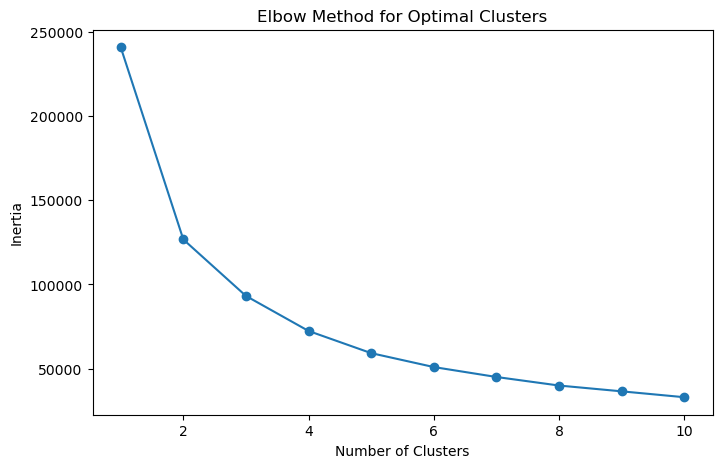

In [178]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Preprocess the data
X_scaled = scaler.fit_transform(X)

# Step 2: Dimensionality Reduction with PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# Step 3: Determine the optimal number of clusters using the elbow method
inertia = []
range_n_clusters = range(1, 11)  # Test clusters from 1 to 10
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()



/opt/miniconda3/envs/new/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/new/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

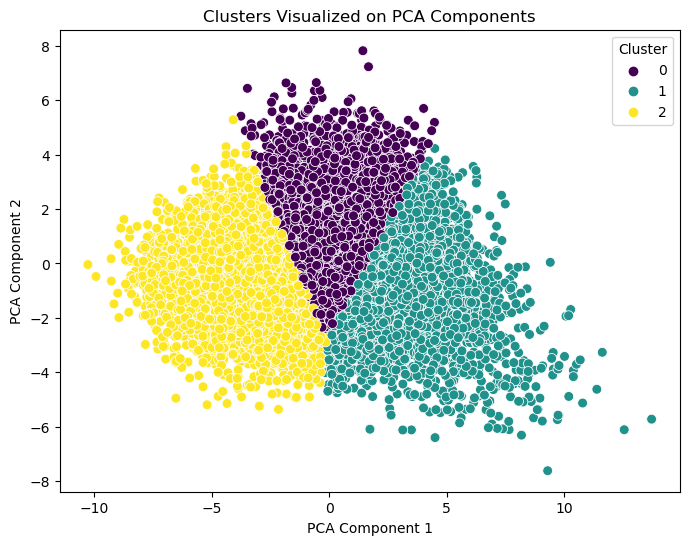

In [182]:
# Step 4: Perform K-Means Clustering with Optimal Number of Clusters
optimal_clusters = 3  # Choose based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Step 5: Visualize the Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title('Clusters Visualized on PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
cluster_df = df.copy()
# Add cluster labels to the original data for analysis
cluster_df['Cluster'] = cluster_labels